In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, json, copy, pickle
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, get_sun
from astropy.coordinates import Angle
from astropy.cosmology import Planck18 as cosmo
from astropy import constants
from astropy import units as u
from alerts import get_alerts
from style import output_folder, big_fontsize, base_width, base_height, dpi, CB_color_cycle, bandcols
import seaborn as sns
from astropy.time import Time

from tqdm import tqdm

from scipy.optimize import root
from scipy.interpolate import interp1d
from scipy.integrate import quad, fixed_quad, quadrature, romberg

from flarestack.cosmo import get_rate, define_cosmology_functions
plt.style.use('tableau-colorblind10')

No scratch directory has been set. Using home directory as default.


In [2]:
alerts = get_alerts()

In [3]:
m = alerts['observed'] & (~alerts.retracted)
observed = alerts[m]

In [4]:
N = len(observed.Event.unique())
print(N, 'alerts observed')

56 alerts observed


In [5]:
hese_m = observed.Class == 'HESE'
observed.loc[hese_m, 'Signalness'] = 0.

/afs/ifh.de/user/n/neckerja/scratch/envs/nu_stat/lib/python3.9/site-packages/pandas-1.3.2-py3.9-linux-x86_64.egg/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [6]:
rates = [
    #("TDE", get_rate("tde")),
    ("GRB", get_rate("GRB")),
#     ("TDE (Jetted)", get_rate("tde", rate_name="sun_15_jetted")),
    #("CCSN (Madau)", get_rate("ccsn", rate_name="madau_14", evolution_name="madau_14", kcc_name="madau_14")),
    ("SFR", get_rate("ccsn", rate_name="strolger_15", evolution_name="strolger_15", kcc_name="strolger_15")),
]

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "CCSN (Strolger)": "SFR-like"
}

colors = {
    "TDE": CB_color_cycle[0],
    "GRB": CB_color_cycle[1],
    "CCSN (Madau)": CB_color_cycle[3],
    "CCSN (Strolger)": CB_color_cycle[5],
    "CCSN": CB_color_cycle[5],
    "SFR": CB_color_cycle[5]
}

time_to_use = {
    "GRB": ['24h', '2h'],
    "SFR": ["14d"]
}

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "SFR": "SFR-like"
}

In [7]:
nsteps = 1e3
zrange, step = np.linspace(0.0, 8, int(nsteps + 1), retstep=True)
# cdf_mpc = dict()
pdf_redshift = dict()
cdf_redshift = dict()
zplot = zrange#0.5*(zrange[1:] + zrange[:-1])
dlum_plot = cosmo.luminosity_distance(zplot)

for label, rate in rates:
    
    rate_per_z, nu_flux_per_z, nu_flux_per_source, cumulative_nu_flux = \
            define_cosmology_functions(rate, 1., gamma=2.0)
    
    ypdf = nu_flux_per_z(zplot) / max(cumulative_nu_flux(max(zplot)))
    pdf_redshift[label] = interp1d(zplot, ypdf)
    cdf_redshift[label] = cumulative_nu_flux

/afs/ifh.de/user/n/neckerja/scratch/envs/nu_stat/lib/python3.9/site-packages/astropy/units/quantity.py:614: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/afs/ifh.de/user/n/neckerja/scratch/envs/nu_stat/lib/python3.9/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


/tmp/ipykernel_17749/3141786606.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(dlum_ticks)


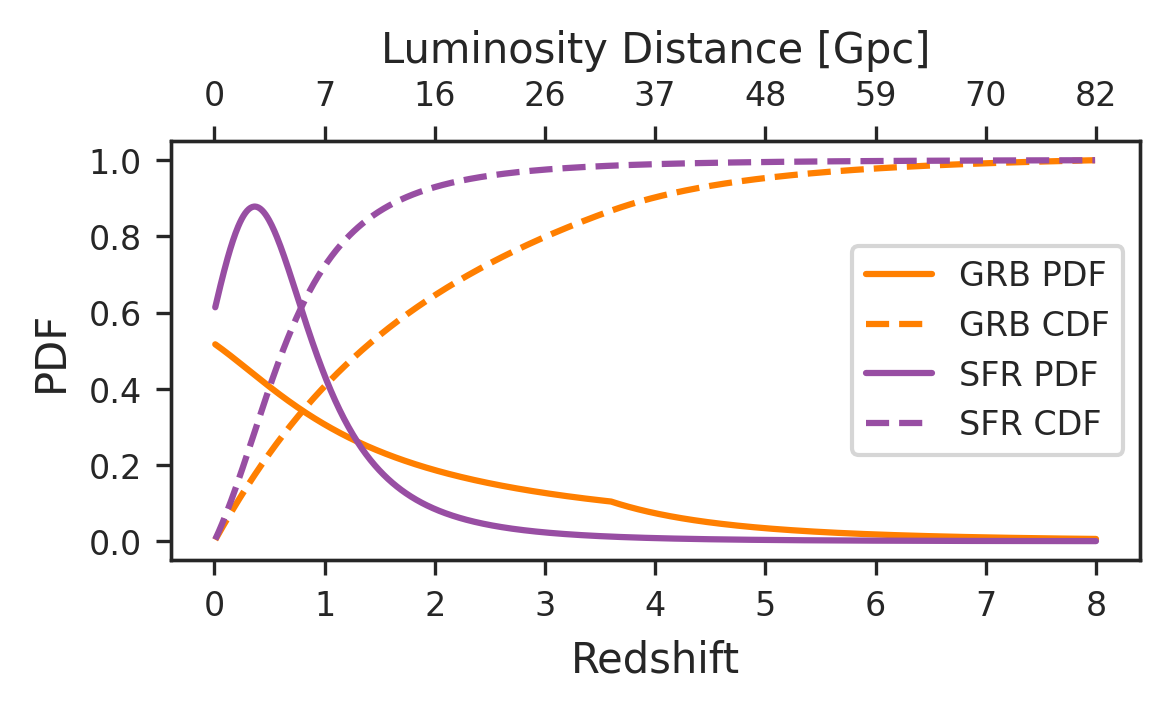

In [10]:
fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)

loglum_range = (1, 5)
# dlum_plot2 = np.logspace(loglum_range[0], loglum_range[1], 1000)
ax2 = ax.twiny()
for label, pdf in pdf_redshift.items():
    ipdf = pdf(zplot)
    ax.plot(zplot, ipdf, label=label + ' PDF', color=colors[label])
    ax2.plot(zplot, ipdf, ls='')
    
    # csum_int = [quad(pdf, 8e-3, z, limit=250)[0] for z in zplot]
    csum = cdf_redshift[label](zplot)
    
    ax.plot(zplot[1:-1], u.Quantity(csum)/max(u.Quantity(csum)), color=colors[label], ls='--', label=label + ' CDF')
    # ax.plot(zplot, csum_int)
# ax.set_xscale('log')
# ax.set_ylim([0, 1])
# ax.set_xlim([10**loglum_range[0], 10**loglum_range[1]])
zticks = ax2.get_xticks()
dlum_ticks = [f'{cosmo.luminosity_distance(iztick).to("Gpc").value:.0f}' for iztick in zticks]
ax2.set_xticklabels(dlum_ticks)
ax2.set_xlabel("Luminosity Distance [Gpc]")
ax.legend()
ax.set_ylabel('PDF')
ax.set_xlabel('Redshift')
fig.tight_layout()
fig.savefig(f"{output_folder}/neutrino_pdfs.pdf")
plt.show()
plt.close()

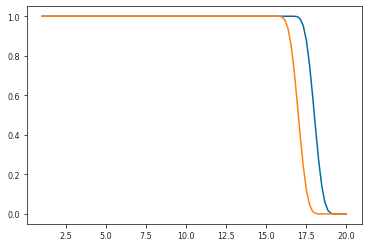

In [166]:
import numpy as np
from scipy.special import comb

def smoothstep(x, x_min=18.5, x_max=15.5, N=5):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)

    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n

    result *= x ** (N + 1)

    return result

completeness_functions = {
    'g': lambda x: smoothstep(x, x_min=19.5, x_max=16.5, N=5),
    'V': lambda x: smoothstep(x, x_min=18.5, x_max=15.5, N=5)
}

xs = np.linspace(1, 20, 100)
for b, f in completeness_functions.items():
    ys = f(xs)
    plt.plot(xs, ys, label=b)

In [112]:
with open("data/completenes_functions.pkl", "rb") as f:
    completenesses = pickle.load(f)
    
completeness_functions = dict()
for band, interpolations in completenesses.items():
    fct = interpolations[0.5]
    def ic(m):
        m = np.atleast_1d(m)
        res = np.zeros(len(m))
        lower_m = m < min(fct.x)
        upper_m = m > max(fct.x)
        res[lower_m] = 1
        res[upper_m] = 0

        no_m = (~lower_m) & (~upper_m)
        res[no_m] = fct(m[no_m])
        return res
        
    completeness_functions[band] = ic

In [104]:
def abs_mag(z, lim_mag):
    
    dl = cosmo.luminosity_distance(z=z).to(u.pc)
    
    ab_mag = lim_mag - 5. * np.log10(dl/(10.*u.pc))
    
    return ab_mag.value

def apparent_mag(z, M):
    return M + cosmo.distmod(z).value

def max_dl(ab_mag, lim_mag):
    
    dl = (10.**(0.2*(lim_mag - ab_mag))) * (10.*u.pc)
    
    return dl.to(u.Mpc)

def abs_mag_to_lum(ab_mag, wl):
    am = (ab_mag * u.ABmag).to(u.Jansky)
    f = (constants.c / wl).to("Hz")
    lum = (am * f * (4. * np.pi * (10. * u.pc)**2.)).to("erg s-1")
    return lum

In [105]:
def pmag(M, pdist, band):
    completeness_f = completeness_functions[band]
    
    def integrand(z):
        return completeness_f(apparent_mag(z, M)) * pdist(z)
    use_z_m = integrand(zplot[1:]) > 0
    use_z = zplot[1:][use_z_m] if np.any(use_z_m) else zplot[1:2]
    integral, e = quad(integrand, min(use_z), max(use_z), limit=250)
    return integral

def P_det(f, M, t, pdist, band):
    P = 1
    _pmag = pmag(M, pdist, band)
    for i, r in observed.iterrows():
        if r.Event == 'IC160731A' and r.Class == 'HESE':
            continue
        P *= 1 - r.Signalness * r[f'{t} coverage']/100 * f * _pmag
    return P

In [113]:
Ms = np.linspace(-21, -30, 100)
Pdets_d = dict()
N_fs = 10
fs = {
    "SFR": {
        "14d": np.linspace(0.11, 1, N_fs)
    },
    "GRB": {
        "2h": np.linspace(0.4, 1, N_fs),
        "24h": np.linspace(0.35, 1, N_fs)
    }
}

cl = 0.9
err = 1 - cl

for label, pdist in pdf_redshift.items():
    band_d = dict()

    for band in ['g', 'V']:
        tdict = dict()

        for t in time_to_use[label]:
            print(label, t)
            ifs = fs[label][t]
            iMs = Ms
            lim = np.empty(len(iMs))

            # for i, f in tqdm(enumerate(ifs), desc='fractions', total=len(ifs)):
            for i, M in tqdm(enumerate(iMs), desc='mags', total=len(iMs)):
                # def minfc(M):
                #     return P_det(f, M, t, pdist) - err
                def minfc(f):
                    return P_det(f, M, t, pdist, band) - err
                res = root(minfc, x0=0.1)

                if res.success:
                    # lim[i] = res.x[0]
                    lim[i] = res.x[0]
                else:
                    raise Exception(res)

            # lim_interp = interp1d(ifs, lim)
            lim_interp = interp1d(iMs, lim)
            tdict[t] = lim_interp
        band_d[band] = tdict
    Pdets_d[label] = band_d

GRB 24h


mags:   0%|                                                                                                                                                | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_30000/3648936193.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, e = quad(integrand, min(use_z), max(use_z), limit=250)
mags: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:36<00:00,  5.77s/it]


GRB 2h


mags: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:40<00:00,  5.80s/it]


GRB 24h


mags: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:28<00:00,  5.69s/it]


GRB 2h


mags: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:36<00:00,  5.76s/it]


SFR 14d


mags: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:11<00:00,  5.51s/it]


SFR 14d


mags: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:10<00:00,  5.51s/it]


In [101]:
m = np.array([9, 10, 11, 12, 15])

def new_fff(mm):
    res = np.zeros(len(mm))
    lower_m = mm < min(fff.x)
    upper_m = mm > max(fff.x)
    res[lower_m] = 1
    res[upper_m] = 0
        
    no_m = (~lower_m) & (~upper_m)
    res[no_m] = fff(mm[no_m])
    return res
        
new_fff(m)

array([1.        , 1.        , 1.        , 0.97678867, 0.90603282,
       0.        ])

In [97]:
min(fff.x)

11.0

In [72]:
Pdets_d

{'GRB': {'g': {'24h': <scipy.interpolate.interpolate.interp1d at 0x7f745ca4a270>,
   '2h': <scipy.interpolate.interpolate.interp1d at 0x7f745ca4a310>},
  'V': {'24h': <scipy.interpolate.interpolate.interp1d at 0x7f745ca4a720>,
   '2h': <scipy.interpolate.interpolate.interp1d at 0x7f745ca4a090>}},
 'SFR': {'g': {'14d': <scipy.interpolate.interpolate.interp1d at 0x7f745ca4a1d0>},
  'V': {'14d': <scipy.interpolate.interpolate.interp1d at 0x7f745ca4a810>}}}

In [73]:
average_absolute_magnitudes = {
    'TDE': -19.5,
    'SN IIn': -18.53
#     'SN Ib': -17.45,
#     'SN Ic': -17.66,
    
}

mags_labels = {
    'SN IIn': 'CCSN',
    'TDE': 'TDE'
}

mag_label_map = np.array([
    ('SN IIn', 'CCSN'),
    ('TDE', 'TDE'),
    ('GRB', 'GRB'),
    ('SN IIn', 'SFR')
])

SFR: 74.17% over -23 at 14d
GRB: 77.14% over -25 at 24h
GRB: 80.42% over -28 at 2h


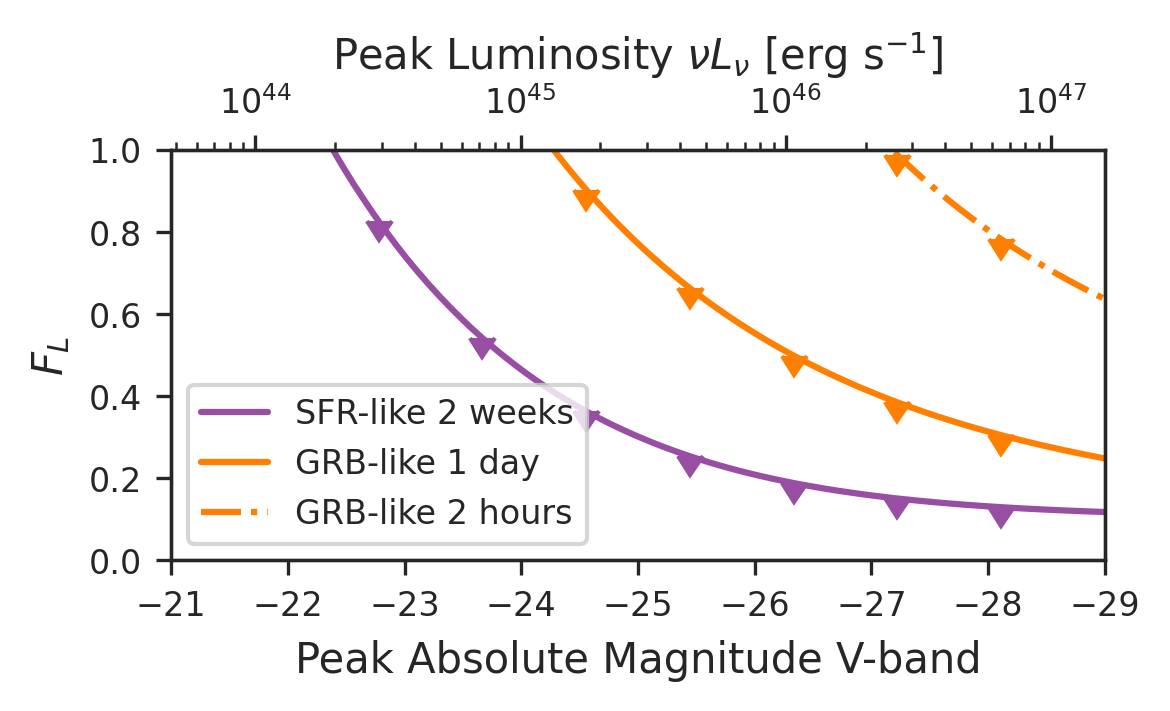

In [114]:
wl = 470*u.nm
lim_mag = {'2h': 17, '24h': 17, '14d': 17}

ls = {'2h': '--', '14d': '-'}
a = {'2h': 0.5, '14d': 1}

time_to_use = {
    "GRB": ['24h', '2h'],
    "SFR": ["14d"]
}

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "SFR": "SFR-like"
}

average_absolute_magnitudes = {
    'SFR': {
        '14d': -23
    },
    'GRB': {
        '2h': -28,
        '24h': -25
    }
}

maxfs = dict()
band = 'V'


fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
abs_mag = np.linspace(-21, -29, 1000)

for i, rate in enumerate(["SFR", "GRB"]):

    # f = cdf_mpc[rate]
    for iti, ti in enumerate(time_to_use[rate]):
        lims = Pdets_d[rate][band][ti]
        ifs = fs[rate][ti]
        plot_fs = np.linspace(min(ifs), max(ifs), 1000)

        tistr = {
            '24h': '1 day',
            '14d': '2 weeks',
            '2h': '2 hours'
        }[ti]
        l = labels[rate] + ' ' + tistr
        ls = ['-', '-.'][iti]
        # ax.plot(lims(plot_fs), plot_fs, label=l, color=colors[rate], ls=ls)
        ax.plot(abs_mag, lims(abs_mag), label=l, color=colors[rate], ls=ls)
        # factor = np.random.normal(1, scale=0.1)
        mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
        eb = ax.errorbar(mag_scatter, lims(mag_scatter), yerr=0.0, uplims=True, color=colors[rate], linestyle="",
                    capsize=0, mew=1)

        # tr = np.array(list(mags_labels.keys()))[np.array(list(mags_labels.values())) == rate]
        #if len(tr) == 0:
         #   continue
        Mag = average_absolute_magnitudes[rate][ti]
        print(f"{rate}: {lims(Mag)*100:.2f}% over {Mag} at {ti}")

#for t, ils in ls.items():
#    ax.plot([],[], label=t, ls=ils, color='grey')        

# for tr, Mag in average_absolute_magnitudes.items():
#     if "TDE" in tr:
#         continue
#     ax.axvline(Mag, label=tr, color=colors[mag_label_map[:,1][mag_label_map[:,0] == tr][0]], ls='dotted')

    
ax.set_xlim((max(abs_mag), min(abs_mag)))
ax2 = ax.twiny()
ax2.plot(abs_mag_to_lum(abs_mag, wl), lims(abs_mag), ls='')
ax2.set_xscale('log')
ax.set_ylim((0, 1))
ax.legend(ncol=1)

ax.set_xlabel(f'Peak Absolute Magnitude {band}-band')
ax2.set_xlabel('Peak Luminosity $\\nu L_{\\nu}$ [erg s$^{-1}$]')
ax.set_ylabel('$F_{L}$')
fig.tight_layout()
# fig.savefig(f"{output_folder}/limits_{cl*100:.0f}cl_notde.pdf")
plt.show()
plt.close()

SFR V: 120.99% over -22 at 14d
GRB V: 40.94% over -27 at 24h
GRB V: 105.12% over -27 at 2h
SFR g: 120.99% over -22 at 14d
GRB g: 40.94% over -27 at 24h
GRB g: 105.12% over -27 at 2h


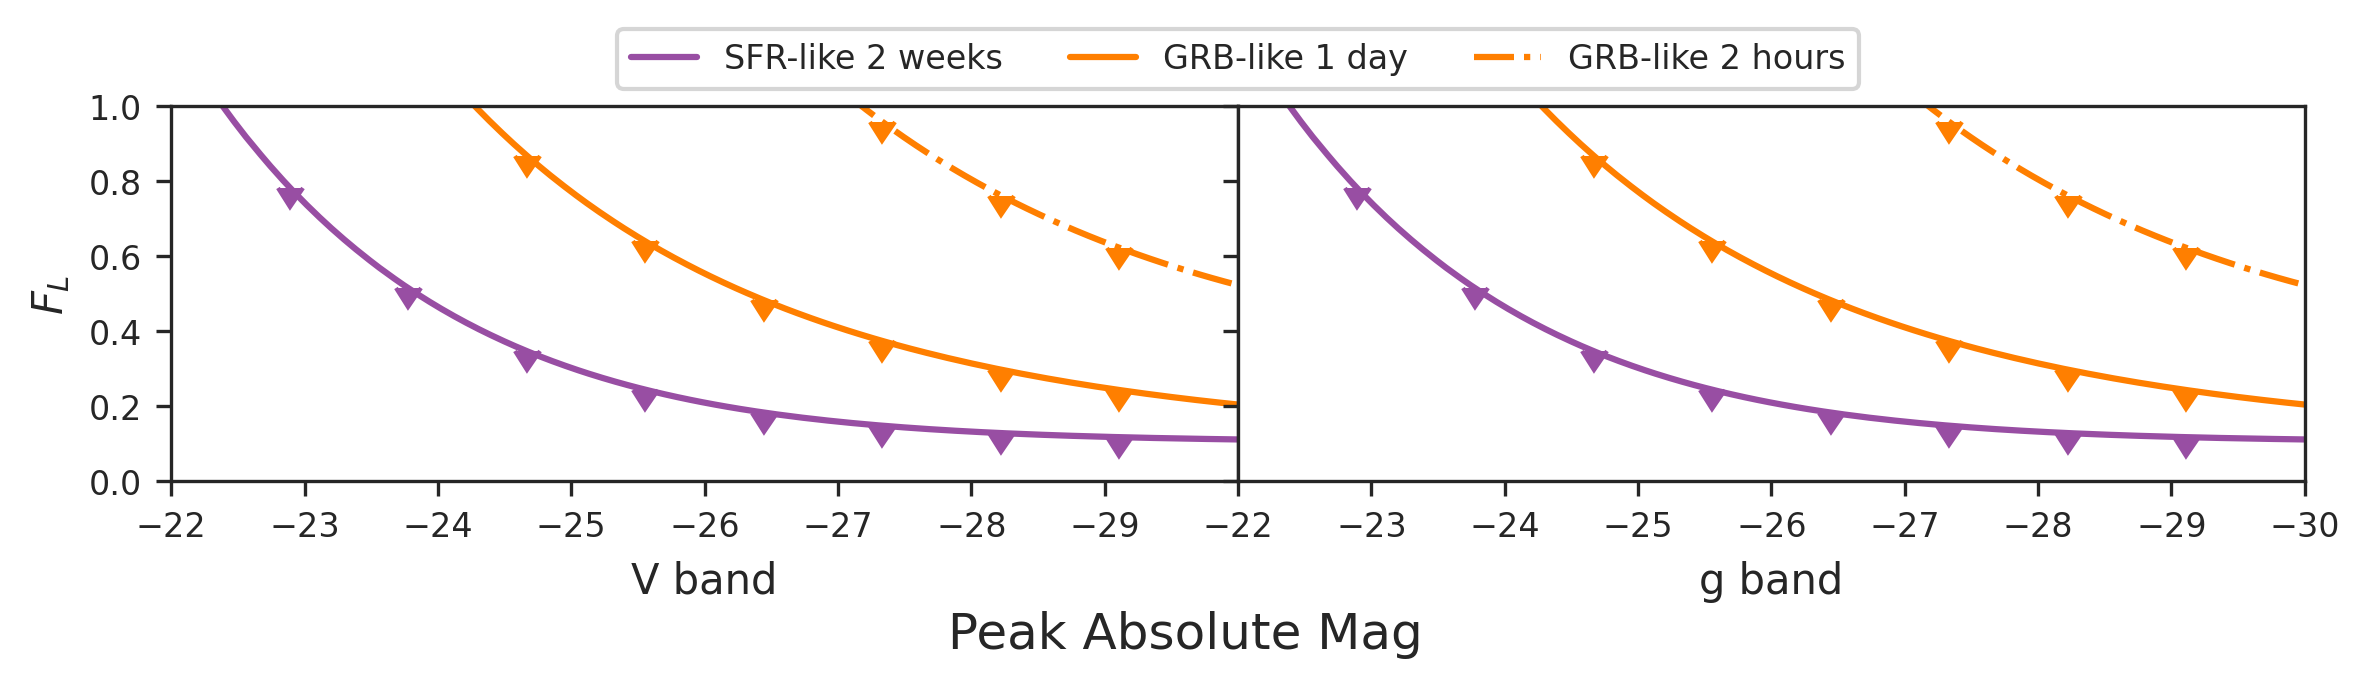

In [117]:
wl = 470*u.nm
lim_mag = {
    'V': {'2h': 16.5, '24h': 16.5, '14d': 16.5},
    'g': {'2h': 17.5, '24h': 17.5, '14d': 17.5}
}

ls = {'2h': '--', '14d': '-'}
a = {'2h': 0.5, '14d': 1}

time_to_use = {
    "GRB": ['24h', '2h'],
    "SFR": ["14d"]
}

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "SFR": "SFR-like"
}

average_absolute_magnitudes = {
    'SFR': {
        '14d': -22
    },
    'GRB': {
        '2h': -27,
        '24h': -27
    }
}

maxfs = dict()


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(base_width*2, base_height*1.1), dpi=dpi, sharey='all',
                      gridspec_kw={'wspace': 0})
abs_mag_band = {
    'V': np.linspace(-22, -30, 1000),
    'g': np.linspace(-22, -30, 1000)
}

for iband, (ax, band) in enumerate(zip(axs, ['V', 'g'])):
    abs_mag = abs_mag_band[band]

    for i, rate in enumerate(["SFR", "GRB"]):

        # f = cdf_mpc[rate]
        for iti, ti in enumerate(time_to_use[rate]):
            
            lims = Pdets_d[rate][band][ti]

            tistr = {
                '24h': '1 day',
                '14d': '2 weeks',
                '2h': '2 hours'
            }[ti]
            l = labels[rate] + ' ' + tistr
            ls = ['-', '-.'][iti]
            ax.plot(abs_mag, lims(abs_mag), label=l, color=colors[rate], ls=ls)
            mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
            eb = ax.errorbar(mag_scatter, lims(mag_scatter), yerr=0.0, uplims=True, color=colors[rate], linestyle="",
                        capsize=0, mew=1)
            

            Mag = average_absolute_magnitudes[rate][ti]
            print(f"{rate} {band}: {lims(Mag)*100:.2f}% over {Mag} at {ti}")
    
    Nticks = max(abs_mag) - min(abs_mag) + 1
    _s = max(abs_mag)
    _e = min(abs_mag) 
    if iband == 0:
        _e += 1
        Nticks -= 1
    
    xticks = np.linspace(_s, _e, num=int(Nticks))
    ax.set_xticks(xticks)
    ax.set_xlim((max(abs_mag), min(abs_mag)))
    ax.set_ylim((0, 1))

    ax.set_xlabel(f'{band} band')

axs[0].set_ylabel('$F_{L}$')
axs[0].legend(bbox_to_anchor = (1,1.25), ncol=3, loc='upper center')
    
fig.supxlabel('Peak Absolute Mag', y=0.1)
fig.tight_layout()
# fig.savefig(f"{output_folder}/limits_{cl*100:.0f}cl_notde_separate_bands.pdf")
plt.show()
plt.close()

SFR: 87.69% over -22 at 14d
GRB: 34.97% over -27 at 24h
GRB: 89.78% over -27 at 2h


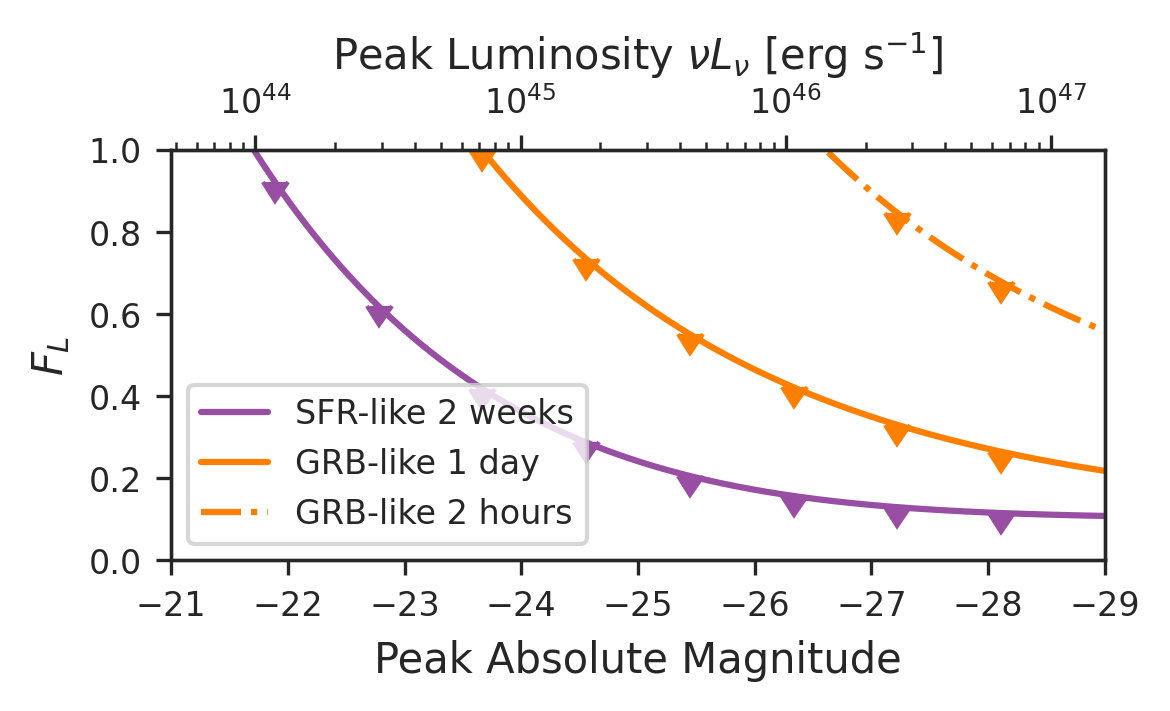

In [23]:
wl = 470*u.nm
lim_mag = {'2h': 18, '24h': 18, '14d': 18}

ls = {'2h': '--', '14d': '-'}
a = {'2h': 0.5, '14d': 1}

time_to_use = {
    "GRB": ['24h', '2h'],
    "SFR": ["14d"]
}

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "SFR": "SFR-like"
}

average_absolute_magnitudes = {
#     'TDE': -19.5,
    'SN IIn': -22,
#     'CCSN': -18.53,
    'GRB': -27
}

maxfs = dict()


fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
abs_mag = np.linspace(-21, -29, 1000)

for i, rate in enumerate(["SFR", "GRB"]):

    f = cdf_mpc[rate]
    for iti, ti in enumerate(time_to_use[rate]):
        iul = ul[ti]
        def max_f(abs_mags):
            res = iul/f(max_dl(abs_mags, lim_mag[ti]))
            return res

        tistr = {
            '24h': '1 day',
            '14d': '2 weeks',
            '2h': '2 hours'
        }[ti]
        l = labels[rate] + ' ' + tistr
        ls = ['-', '-.'][iti]
        ax.plot(abs_mag, max_f(abs_mag), label=l, color=colors[rate], ls=ls)
        factor = np.random.normal(1, scale=0.1)
        mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
        eb = ax.errorbar(mag_scatter, max_f(mag_scatter), yerr=0.0, uplims=True, color=colors[rate], linestyle="",
                    capsize=0, mew=1)

        tr = np.array(list(mags_labels.keys()))[np.array(list(mags_labels.values())) == rate]
        #if len(tr) == 0:
         #   continue
        Mag = average_absolute_magnitudes[rate][ti]
        print(f"{rate}: {lims(Mag)*100:.2f}% over {Mag} at {ti}")

#for t, ils in ls.items():
#    ax.plot([],[], label=t, ls=ils, color='grey')        

# for tr, Mag in average_absolute_magnitudes.items():
#     if "TDE" in tr:
#         continue
#     ax.axvline(Mag, label=tr, color=colors[mag_label_map[:,1][mag_label_map[:,0] == tr][0]], ls='dotted')

    
ax.set_xlim((max(abs_mag), min(abs_mag)))
ax2 = ax.twiny()
ax2.plot(abs_mag_to_lum(abs_mag, wl), max_f(abs_mag), ls='')
ax2.set_xscale('log')
ax.set_ylim((0, 1))
ax.legend(ncol=1)

ax.set_xlabel('Peak Absolute Magnitude')
ax2.set_xlabel('Peak Luminosity $\\nu L_{\\nu}$ [erg s$^{-1}$]')
ax.set_ylabel('$F_{L}$')
fig.tight_layout()
fig.savefig(f"{output_folder}/limits_{cl*100:.0f}cl_notde.pdf")
plt.show()
plt.close()

In [70]:
xticks

array([], dtype=float64)

KeyError: '1h'

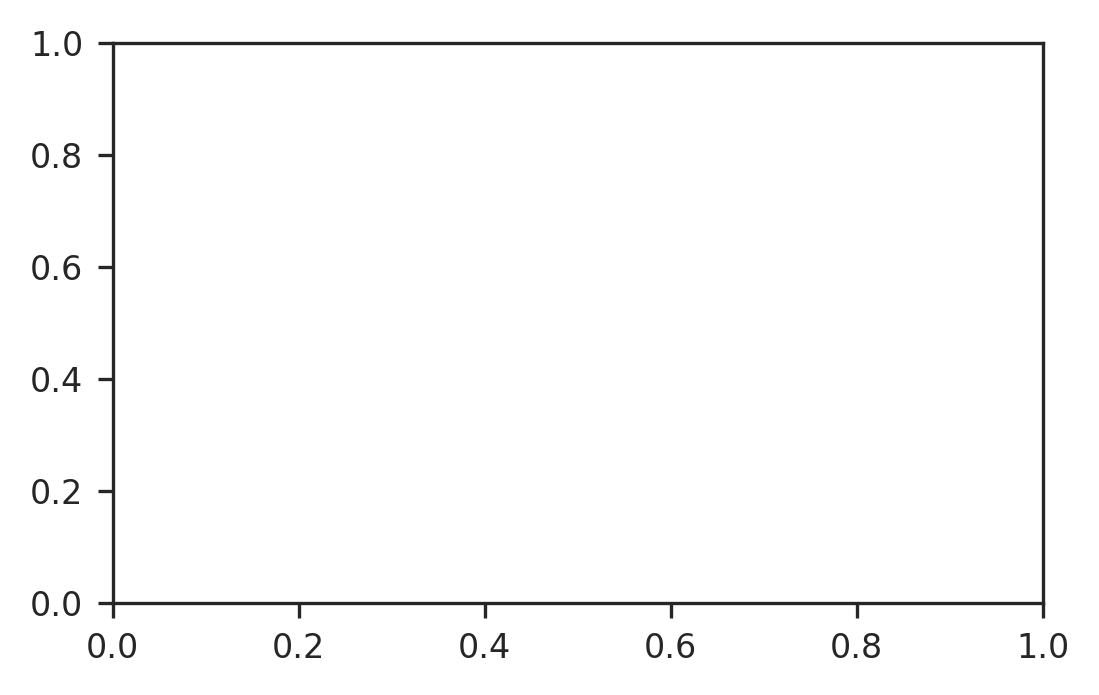

In [21]:
lim_mag = {'1d': 18.5, '14d': 18.5}

wl = 470*u.nm

xlim = {'1d': (-19, -27), '14d': (-15, -24)}

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "CCSN (Strolger)": "SFR-like"
}

maxfs = dict()

for t, iul in ul.items():

    fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
    xl = xlim[t]
    abs_mag = np.linspace(max(xl), min(xl), 1000)
    ax2 = ax.twiny()

    for i, rate in enumerate(["CCSN (Strolger)", "GRB"]):
        f = cdf_mpc[rate]

        def max_f(abs_mags):
            res = iul/f(max_dl(abs_mags, lim_mag[t]))
            return res

        ax.plot(abs_mag, max_f(abs_mag), label=labels[rate], color=colors[rate])
        mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
        ax.errorbar(mag_scatter, max_f(mag_scatter), yerr=0.04, uplims=True, color=colors[rate], linestyle=" ")
        
#         if rate == 'TDE':
#             ax.plot(abs_mag, get_lumf(rate, abs_mag_to_lum(abs_mag, wl), **{'min_lum': 1e40*u.erg/u.s}))

    for tr, Mag in average_absolute_magnitudes.items():
        ax.axvline(Mag, label=tr, color=colors[mags_labels[tr]], ls='dotted')
        
    ax.set_xlim((max(abs_mag), min(abs_mag)))
    ax2.plot(abs_mag_to_lum(abs_mag, wl), max_f(abs_mag), ls='')
    ax2.set_xscale('log')
    ax.set_ylim((0, 1))
    ax.legend(ncol=2, loc='upper right')
    


    ax.set_xlabel('Peak Absolute Magnitude')
    ax2.set_xlabel('Peak Luminosity $\\nu L_{\\nu}$ [erg s$^{-1}$]')
    ax.set_ylabel('$F_{L}$')
    fig.savefig(f"{output_folder}/limits{t}_{cl*100:.0f}cl.pdf")
    
    plt.show()
    plt.close()

KeyError: 'TDE'

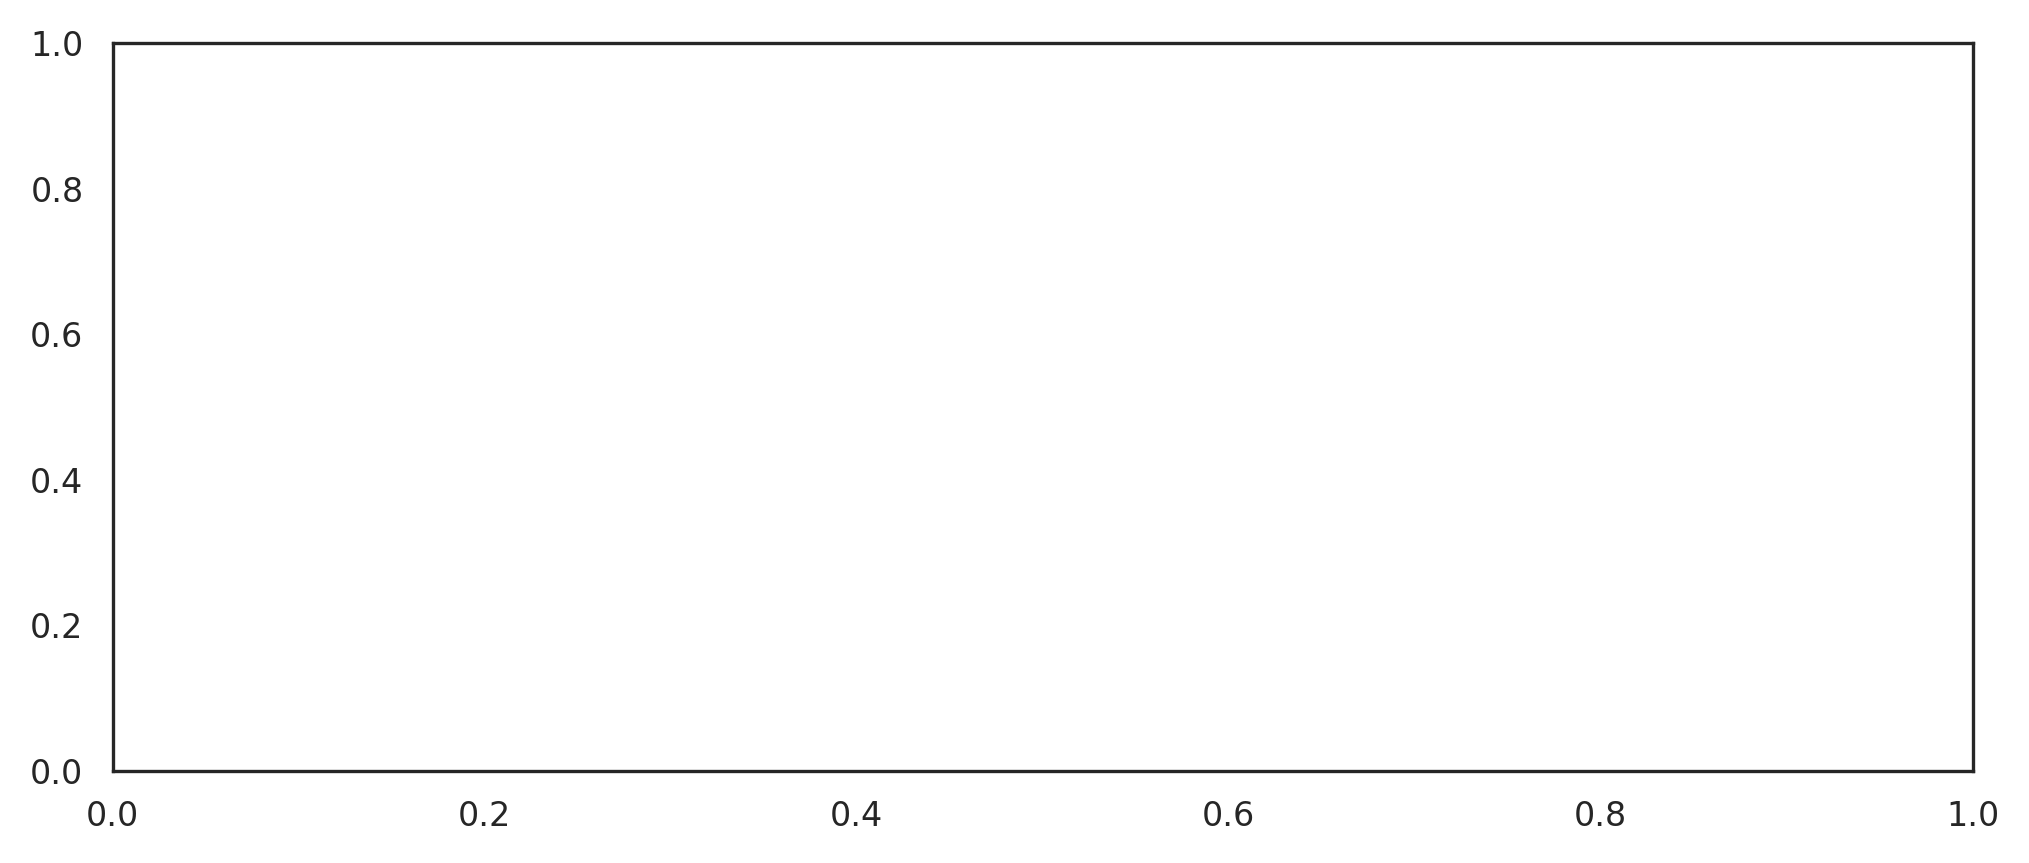

In [69]:
wl = 470*u.nm

ls = {'2h': '--', '14d': '-'}
a = {'2h': 0.5, '14d': 1}

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "CCSN (Strolger)": "SFR-like"
}

maxfs = dict()


fig, ax = plt.subplots(figsize=(base_width*2, base_height*1.3), dpi=dpi)
abs_mag = np.linspace(np.max(list(xlim.values())), np.min(list(xlim.values())), 1000)

for i, rate in enumerate(["TDE", "CCSN (Strolger)", "GRB"]):

    for t, iul in ul.items():

        f = cdf_mpc[rate]

        def max_f(abs_mags):
            res = iul/f(max_dl(abs_mags, lim_mag[t]))
            return res

        l = labels[rate] if t=='14d' else ''
        ax.plot(abs_mag, max_f(abs_mag), label=l, color=colors[rate], ls=ls[t])
        factor = np.random.normal(1, scale=0.1)
        mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
        eb = ax.errorbar(mag_scatter, max_f(mag_scatter), yerr=0.0, uplims=True, color=colors[rate], linestyle="",
                    capsize=0, mew=1)
        
        tr = np.array(list(mags_labels.keys()))[np.array(list(mags_labels.values())) == rate]
        if len(tr) == 0:
            continue
        Mag = average_absolute_magnitudes[tr[0]]
        print(f"{rate} {tr[0]}: {max_f(Mag)}% over {Mag}")

for t, ils in ls.items():
    ax.plot([],[], label=t, ls=ils, color='grey')        

for tr, Mag in average_absolute_magnitudes.items():
    ax.axvline(Mag, label=tr, color=colors[mags_labels[tr]], ls='dotted')

    
ax.set_xlim((max(abs_mag), min(abs_mag)))
ax2 = ax.twiny()
ax2.plot(abs_mag_to_lum(abs_mag, wl), max_f(abs_mag), ls='')
ax2.set_xscale('log')
ax.set_ylim((0, 1))
ax.legend(ncol=3)

ax.set_xlabel('Peak Absolute Magnitude')
ax2.set_xlabel('Peak Luminosity $\\nu L_{\\nu}$ [erg s$^{-1}$]')
ax.set_ylabel('$F_{L}$')
fig.tight_layout()
fig.savefig(f"{output_folder}/limits_{cl*100:.0f}cl.pdf")
plt.show()
plt.close()

In [39]:
np.array(list(mags_labels.values())) == rate

array([False,  True])

In [143]:
import tarfile

In [144]:
with tarfile.open('data/1006.4612', 'r') as tar:
    tar.extractall('data/sn_lf')

In [15]:
output_folder

'../figures/'